# Finding classical parameters for the up sector

Here I set the number of up electrons and let the down electrons be anything they want.  Let us break the wavefunction up into a sum over the up electron states:
$$|\psi> = \sum_c \alpha_c|c>|\psi^{\downarrow}> $$
where $|c>$ is a particular state of the up electrons which is stored classically, $|\psi^{\downarrow}>$ is the state of the down electrons, and $\alpha_c$ are some set of parameters which will be updated during VQE along with the unitary that describes $|\psi^{\downarrow}>$

We can calculate the energy expaection value (which is the cost function for VQE) using a set of classical derived parameters describing the up states and a set of Pauli expectation values which will be found using VQE.

\begin{equation}
\begin{split}
<\psi|H|\psi> &= \sum_{c,c'}\alpha_c\alpha_{c'}^{*}<c'|<\psi^{\downarrow}| H|c>|\psi^{\downarrow}> 
\\
& = \sum_{c,c'}\alpha_c\alpha_{c'}^{*} \left( <c'|\hat{K}^{\uparrow}|c> + \delta_{c',c}<\psi^{\downarrow}|\hat{K}^{\downarrow}|\psi^{\downarrow}> + u\sum_i <c'|\hat{n_i}^{\uparrow}|c><\psi^{\downarrow}|\hat{n}_i^{\downarrow} |\psi^{\downarrow}> \right)
\\
& = \sum_{c,c'}\alpha_c\alpha_{c'}^{*} \left( k_{c',c} + \delta_{c',c}\sum_i\left( t<\psi^{\downarrow}|X_i X_{i+1} |\psi^{\downarrow}> +t<\psi^{\downarrow}|Y_i Y_{i+1} |\psi^{\downarrow}> + u_{i,c}<\psi^{\downarrow}|Z_i |\psi^{\downarrow}> + u_{i,c} \right) \right)
\end{split}
\end{equation}
where $\hat{n}_i^{\sigma}$ is the number operator on site $i$ for spin $\sigma$, $\hat{K}^{\sigma}$ is the kinetic part of the Hamiltonian for spin $\sigma$, $t$ is the hopping strength,  $u$ is the interaction strength, $k_{c',c} = <c'|\hat{K}^{\uparrow}|c>$, and  $u_{i,c} = u<c'|\hat{n_i}^{\uparrow}|c>$.  

Here we will find $k_{c',c}$ and $u_{i,c}$. 

In [145]:
import numpy as np
import pandas as pd
from qiskit import quantum_info as qi

First we need a way to generate the spin up states

In [146]:
#Creates all states with N fermions and S orbitals
def Generate_States(N,S):
    s = [i for i in range(0,N)]
    psi_l = []
    while s[0] < S-N:
        ### create the state and store it
        psi = 0
        for i in s:
            psi += 2**i
        psi_l.append(psi)
        ###
        ###Update the particle locations
        exit = 0
        i = len(s)-1
        while exit == 0:
            if s[i] < S-len(s)+i:
                s[i] += 1
                for j in range(i+1,len(s)):
                    s[j] = s[j-1]+1
                exit = 1
            else:
                i -= 1
        ###
    ###Create the finale state
    psi = 0
    for i in s:
        psi += 2**i
    psi_l.append(psi)
    ###
    return psi_l

In [147]:
states = Generate_States(2,4)
states

[3, 5, 9, 6, 10, 12]

In [148]:
# A function to print out the binary number
def bi(num,S):
    bi = bin(num)
    out = ""
    Sdiff = S - len(bi) + 2
    for i in range(0,Sdiff):
        out = out + '0'
    for i in range(2,len(bi)):
        out = out + bi[i]
    return out

In [149]:
bi(states[1],4)

'0101'

Now we can find the $k_{c,c}$ parameter by finding the action of the kinetic terms on the spin up states.

In [150]:
def bi_t(V,Su):
    Vn_l = []
    sign = 0
    for i in range(0,Su):
        #Spin up
        M = 2**i + 2**np.mod(i+1,Su)
        K = M & V
        L = K ^ M
        if L != 0 and L != M:
            Vn = V - K + L
            if i + 1 == np.mod(i+1,Su):
                sign = 1
            elif Su % 2 == 1:
                sign = 1
            else:
                sign = -1
            #print(i,':',bi(Vn))
            Vn_l.append([Vn,sign])
        #Spin down
        #Only doing spin up
    return Vn_l

In [151]:
t = -1
S = 4
Q = len(states)
index_map = {states[i]:i for i in range(Q)}
K_up = np.array([[0 for i in range(Q)] for j in range(Q)])
for i in range(0,Q):
    psi_t = bi_t(states[i],S)
    for s in range(len(psi_t)):
        K_up[index_map[psi_t[s][0]],i] = psi_t[s][1]*t


        
K_up

array([[ 0, -1,  0,  0,  1,  0],
       [-1,  0, -1, -1,  0,  1],
       [ 0, -1,  0,  0, -1,  0],
       [ 0, -1,  0,  0, -1,  0],
       [ 1,  0, -1, -1,  0, -1],
       [ 0,  1,  0,  0, -1,  0]])

Now we can find the $u_{i,c}$ parameter by simply checking whether there is a spin up electron at site $i$ in state $c$

In [152]:
def bi_n(i,V,S):
    num = bi(V,S)
    if num[-i-1] == '1':
        return 1
    else:
        return 0

In [153]:
print(bi(states[2],4))
bi_n(0,states[2],4)

1001


1

In [154]:
u = 1
S = 4
Q = len(states)
n_up = []
for c in range(0,Q):
    n_up_c = []
    for i in range(0,S):
        n_up_c.append(u*bi_n(i,states[c],S))
    n_up.append(n_up_c)
    
n_up

[[1, 1, 0, 0],
 [1, 0, 1, 0],
 [1, 0, 0, 1],
 [0, 1, 1, 0],
 [0, 1, 0, 1],
 [0, 0, 1, 1]]

Recall that

\begin{equation}
\begin{split}
<\psi|H|\psi> = \sum_{c,c'}\alpha_c\alpha_{c'}^{*}  k_{c',c} + \sum_{c}|\alpha_c|^2\sum_i\left( t<\psi^{\downarrow}|X_i X_{i+1} |\psi^{\downarrow}> +t<\psi^{\downarrow}|Y_i Y_{i+1} |\psi^{\downarrow}> + u_{i,c}<\psi^{\downarrow}|Z_i |\psi^{\downarrow}> + u_{i,c} \right) 
\end{split}
\end{equation}

## Full Hamiltonian

Even though we will not use it directly, let us write the full Hamiltonian so that we can compare our results.  The Hamiltoniain is:

\begin{equation}
    H_{c,c'} = k_{c,c'}\hat{I}_{\downarrow} + \delta_{c,c'}\left(\sum_{i=0}^{S-2}\left(X_i X_{i+1} + Y_i Y_{i+1}\right) + X_0Z_1Z_2...Z_{N-2}X_{N-1}+ Y_0Z_1Z_2...Z_{N-2}Y_{N-1}\right) + \delta_{c,c'}\sum_i u_{i,c}\left(\hat{I}_{\downarrow}+Z_i\right)
\end{equation}

In [155]:
I_down = [[0 for i in range(2**S)] for j in range(2**S)]
for i in range(2**S):
    I_down[i][i] = 1
I_down = np.array(I_down)
    
def Z_label(i,Q):
    out = ''
    for j in range(0,Q):
        if j == i:
            out = out + 'Z'
        else:
            out = out + 'I'
    return out[::-1]


def X_label(i,Q):
    out = ''
    for j in range(0,Q):
        if i < Q-1:
            if i == j or i + 1 == j:
                out = out + 'X'
            else:
                out = out + 'I'
        else:
            if j == 0 or j == Q-1:
                out = out + 'X'
            else:
                out = out + 'Z'
    return out[::-1]

def Y_label(i,Q):
    out = ''
    for j in range(0,Q):
        if i < Q-1:
            if i == j or i + 1 == j:
                out = out + 'Y'
            else:
                out = out + 'I'
        else:
            if j == 0 or j == Q-1:
                out = out + 'Y'
            else:
                out = out + 'Z'
    return out[::-1]
    
def Hcc(c,cc):
    h = K_up[c][cc]*I_down
    if c == cc:
        for i in range(0,S): 
            h = h + t*qi.Operator.from_label(X_label(i,S)).data
            h = h + t*qi.Operator.from_label(Y_label(i,S)).data
            h = h + u*n_up[c][i]*(I_down + qi.Operator.from_label(Z_label(i,S)).data)
    return np.array(h)
            


In [156]:
Nc = 6
Ndown = 2**S
H_full = [[0 for i in range(Nc*Ndown)] for j in range(Nc*Ndown)]
for c in range(Nc):
    for i in range(Ndown):
        for cc in range(Nc):
            for j in range(Ndown):
                H_full[Ndown*c + i][Ndown*cc + j] = Hcc(c,cc)[i][j]

In [157]:
e,y = np.linalg.eig(H_full)

np.sort(e)

array([-5.13312893e+00+1.00234397e-18j, -5.13312893e+00+6.66133815e-16j,
       -4.73997938e+00-7.36620420e-22j, -4.62935704e+00-1.43602894e-18j,
       -3.82953081e+00-2.62378430e-18j, -3.59930037e+00+6.05919306e-18j,
       -3.32088450e+00-5.39340687e-17j, -3.28356705e+00-4.12624181e-16j,
       -3.13312893e+00+1.06051188e-17j, -3.13312893e+00+2.07504377e-17j,
       -2.57649122e+00-1.27559780e-17j, -2.57649122e+00+1.29908112e-17j,
       -2.00000000e+00+7.04163900e-17j, -2.00000000e+00+5.55672117e-16j,
       -2.00000000e+00-9.57383454e-17j, -2.00000000e+00+0.00000000e+00j,
       -1.62007586e+00-5.47612867e-18j, -1.35193920e+00+2.00074611e-17j,
       -1.32088450e+00-1.60693988e-16j, -1.30205302e+00+6.57961658e-17j,
       -1.30205302e+00+6.66133815e-16j, -1.28356705e+00-2.83234406e-17j,
       -9.93825263e-01+6.96620637e-18j, -6.72823701e-01+3.90766610e-17j,
       -5.13402783e-01+3.12239245e-17j, -3.36508804e-01-1.88930346e-17j,
       -1.14091954e-15+5.22157126e-18j,  1.66706805

## The Ansatz

Here we define the paramaterized circuit which we will optimize. 

$$ U^c_i = \prod_q R^y_q(\phi_{q0}^c)\prod_{q'}C_{4q',4q'+1}C_{4q'+3,4q'+2}\prod_{q''}C_{4q''+1,4q''+2}C_{4q''+4,4q''+3} $$
$$ U^c = \prod_i U^c_i $$

This has to be optimized along with the paramter set $\{\alpha_c\}$

In [158]:
from qiskit import QuantumCircuit, QuantumRegister,ClassicalRegister, execute


In [159]:
def Ui(cir_i,phi_i):  
    
    for q in range(0,Q):
        cir_i.ry(phi_i[q],q)
    for q in range(0,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    for q in range(1,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    
    return cir_i


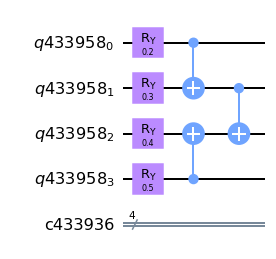

In [160]:
Q = 4
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir_i = QuantumCircuit(qr , cr)
tst = Ui(cir_i,[0.2,0.3,0.4,0.5])

tst.draw(output = 'mpl')

In [161]:
def U(cir,phi_b):
    T = len(phi_b)
    for t in range(T):
        cir = Ui(cir,phi_b[t])
    return cir


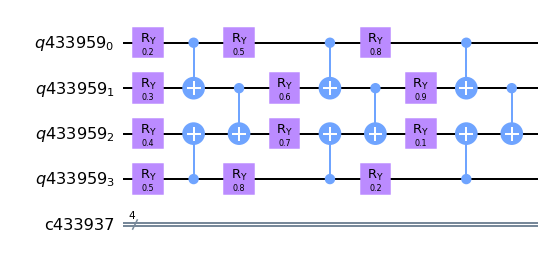

In [162]:
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
tst = U(cir,[[0.2,0.3,0.4,0.5],[0.5,0.6,0.7,0.8],[0.8,0.9,0.1,0.2]])

tst.draw(output = 'mpl')

# Calculating E

\begin{equation}
\begin{split}
E =& <\psi|H|\psi> 
\\
=& \sum_{c,c'}\alpha_c\alpha_{c'}^{*}  k_{c',c} + \sum_{c}|\alpha_c|^2\times
\\
&\sum_i \left( t<000\ldots|U^{\dagger}(\{\phi^c\})X_i X_{i+1} U(\{\phi^c\})|000\ldots> \right.
\\
&+t<000\ldots|U^{\dagger}(\{\phi^c\})Y_i Y_{i+1} U(\{\phi^c\})|000\ldots> 
\\
&\left.+ u_{i,c}<000\ldots|U^{\dagger}(\{\phi^c\})Z_i U(\{\phi^c\})|000\ldots> + u_{i,c} \right)
\end{split}
\end{equation}

We can use the Pauli calculator from the other VQE file.


In [163]:
from qiskit import Aer
from qiskit.visualization import *
from qiskit import quantum_info as qi

def measure_pauli(p_label,psi0,method = 'simple'):
    
    #Simple method of calculation####
    if method == 'simple':
        wave0 = qi.Statevector.from_instruction(psi0)
        Op = qi.Operator.from_label(p_label)
        return np.dot(np.conjugate(wave0),np.dot(Op,wave0))
    #################################
        
    #apply rotations#################
    psi = copy.deepcopy(psi0)
    pauli_qs = []
    Z_label = ''
    Q = len(p_label)
    for q,p in enumerate(p_label):
        if p == 'X':
            psi.ry(-np.pi/2,Q-1-q)
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'Y':
            psi.rx(np.pi/2,Q-1-q)
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'Z':
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'I':
            pauli_qs.append(0)
            Z_label += 'I'
    ################################
    
    #Using matrix multiplication####
    if method == 'matrix':
        # add results
        wave = qi.Statevector.from_instruction(psi)
        r = wave.probabilities_dict()
        z_measure = 0
        for key in list(r.keys()):
            n = 0
            for q in range(len(key)):
                if key[q] == '1' and pauli_qs[q] == 1:
                    n += 1
            z_measure += (-1)**n * r[key] 
        return z_measure
    #################################
    
    #Using the qasm simulator########
    if method == "simulator":
        sim = Aer.get_backend("qasm_simulator")
        psi.measure(psi.qubits,psi.clbits)
        r = execute(psi, backend = sim).result().get_counts()
        z_measure = 0
        total = 0
        for key in list(r.keys()):
            n = 0
            for q in range(len(key)):
                if key[q] == '1' and pauli_qs[q] == 1:
                    n += 1
            z_measure += (-1)**n * r[key] 
            total += r[key]
        return z_measure/total
    ###################################
    
    raise NameError(method + ' is not a recognized method')
    return method + ' is not a recognized method'
  

#Run a test
import copy
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
psi0 = U(cir,[[1.2,2.3,3.4,2.1]])
p_label = "XXII"
        
    
print( measure_pauli(p_label,psi0,method = 'simple') )
print( measure_pauli(p_label,psi0,method = 'matrix') )
print( measure_pauli(p_label,psi0,method = 'simulator') )
#print( measure_pauli(p_label,psi0,method = 'Moon_Cheese') )

(0.8632093666488736+0j)
0.8632093666488737
0.876953125


In [164]:
def Z_label(i,Q):
    out = ''
    for j in range(0,Q):
        if j == i:
            out = out + 'Z'
        else:
            out = out + 'I'
    return out[::-1]


def X_label(i,Q):
    out = ''
    for j in range(0,Q):
        if i < Q-1:
            if i == j or i + 1 == j:
                out = out + 'X'
            else:
                out = out + 'I'
        else:
            if j == 0 or j == Q-1:
                out = out + 'X'
            else:
                out = out + 'Z'
    return out[::-1]

def Y_label(i,Q):
    out = ''
    for j in range(0,Q):
        if i < Q-1:
            if i == j or i + 1 == j:
                out = out + 'Y'
            else:
                out = out + 'I'
        else:
            if j == 0 or j == Q-1:
                out = out + 'Y'
            else:
                out = out + 'Z'
    return out[::-1]

print(Z_label(1,4))
print(X_label(2,4))
print(X_label(3,4))
print(Y_label(1,4))
print(Y_label(3,4))

IIZI
XXII
XZZX
IYYI
YZZY


\begin{equation}
\begin{split}
E =& <\psi|H|\psi> 
\\
=& \sum_{c,c'}\alpha_c\alpha_{c'}^{*}  k_{c',c} + \sum_{c}|\alpha_c|^2\times
\\
&\sum_i \left( t<000\ldots|U^{\dagger}(\{\phi^c\})X_i X_{i+1} U(\{\phi^c\})|000\ldots> \right.
\\
&+t<000\ldots|U^{\dagger}(\{\phi^c\})Y_i Y_{i+1} U(\{\phi^c\})|000\ldots> 
\\
&\left.+ u_{i,c}<000\ldots|U^{\dagger}(\{\phi^c\})Z_i U(\{\phi^c\})|000\ldots> + u_{i,c} \right)
\end{split}
\end{equation}

In [166]:
import numpy as np

def find_E(alpha, phi, method = 'simple'):
    
    # The kinetic part for the up spin
    E_Kup = 0
    for c in range(0,len(alpha)):
        for cc in range(0,len(alpha)):
            E_Kup += alpha[c]*np.conjugate(alpha[cc])*K_up[c][cc]
            
    # The Kinetic part for the down spin
    E_Kdown = 0
    for c in range(0,len(alpha)):
        for i in range(0,Q):
            qr = QuantumRegister(Q)
            cr = ClassicalRegister(Q)
            cir = QuantumCircuit(qr , cr)
            psi0 = U(cir,phi)
            p_label = X_label(i,Q)
            E_Kdown += t*np.abs(alpha[c])**2*measure_pauli(p_label,psi0,method = method)
            p_label = Y_label(i,Q)
            E_Kdown += t*np.abs(alpha[c])**2*measure_pauli(p_label,psi0,method = method)
            
    # Interaction part
    E_u = 0
    for c in range(0,len(alpha)):
        for i in range(0,Q):
            qr = QuantumRegister(Q)
            cr = ClassicalRegister(Q)
            cir = QuantumCircuit(qr , cr)
            psi0 = U(cir,phi)
            p_label = Z_label(i,Q)
            E_u += u*n_up[c][i]*np.abs(alpha[c])**2*measure_pauli(p_label,psi0,method = method)
            E_u += u*n_up[c][i]*np.abs(alpha[c])**2
            
    return E_u + E_Kup + E_Kdown

In [167]:
alpha = [1,2,3,4,5,6]
phi = [[0.2,0.3,0.4,0.5]]
find_E(alpha, phi)

(199.38411750609066+0j)

# I need to check that this is the same energy I get from the full Hamiltonian

In [168]:
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
psi0 = U(cir,phi)

psi_tst = qi.Statevector.from_instruction(psi0).data

In [169]:
psi_tst_full = [0 for i in range(Nc*Ndown)]

for c in range(Nc):
    for i in range(Ndown):
        psi_tst_full[Ndown*c + i] = alpha[c]*psi_tst[i]

In [171]:
find_E(alpha, phi)

(199.38411750609066+0j)

In [172]:
np.dot(psi_tst_full,np.dot(H_full,psi_tst_full))

(199.38411750609058+0j)

Great!  They match so I am at least simulating H_full in the find_E function.  Whether H_full is correct or not is a matter of doing Jordain-Wigner correctly and then copying it down onto the notebook

In [135]:
pwd

'/Users/stenger/Documents/Research/Hubbard_symmetries'

## Optimization

We need to optimize both $\{\alpha\}$ and $\{\phi\}$ keeping in mind that 
$$\sum_c |\alpha_c|^2 = 1$$

For $\{\phi\}$ we will use the same technique as in the first VQE file.

There I used the simultaneous perturbation stochastic approximation algorithm.  The algorithm works by calculating the gradiant of the cost function $E(\hat{\phi})$ by randomly purturbating all parameters in $\hat{\phi}$

Let $\hat{\Delta}_k$ be a set of randomly selected purturbations during step $k$ of the algorithm. I will use the Bernoulli distribution to select $\hat{\Delta}_k$.  Then the gradient is 
$$ \hat{g}_k(\hat{\phi}_k) = \frac{E(\hat{\phi}_k + c_k \hat{\Delta}_k)-E(\hat{\phi}_k - c_k \hat{\Delta}_k)}{2 c_k} \hat{\Delta}_k$$.
The gradiant is then used to update the parameters 
$$ \hat{\phi}_{k+1} = \hat{\phi}_k - a_k \hat{g}_k(\hat{\phi}_k) $$

$c_k$ and $a_k$ decrease with each iteration of the algorithm so that we zero in on the the minimum of $E$.  They are given by
$$c_k = \frac{c}{(k+1)^{\gamma}}$$
$$a_k = \frac{a}{(A+k+1)^{\beta}}$$
where $a$, $A$, $\alpha$, $c$, and $\gamma$ are choosen at the begining of the algorithm.

For $\{\alpha\}$ we will do something similar but we must enforce that $\{\alpha\}$ is normalized.  The normalization has to be applied at two steps.  We again take a set of random perturbations $\hat{\Delta}_{\alpha}$ and update 

$$ \hat{\alpha} = \frac{1}{\sqrt{\sum_c |\alpha_c+ c_{\alpha_c}\Delta_{\alpha_c}|^2}}(\hat{\alpha} + c_{\alpha}\hat{\Delta}_{\alpha}) $$

only this time we have normalized the set.  Then we will take the gradient of the energy and update the set again 
$$ \hat{\alpha} = \frac{1}{\sqrt{\sum_c |\alpha_c- a_{\alpha_c} g_{\alpha_c}|^2}}(\hat{\alpha} - a_{\alpha} \hat{g}_{\alpha}) $$

In [187]:
alpha = 1/np.sqrt(6)*np.array([1,1,1,1,1,1])


T = 2
phi = []
for ti in range(T):
    phi_t = []
    for q in range(Q):
        phi_t.append(0)
    phi.append(phi_t)

find_E(alpha, phi)

(2.666666666666665+0j)

In [188]:
phi

[[0, 0, 0, 0], [0, 0, 0, 0]]

In [189]:
#beta = 0.602
beta = 0.201
A = 10
a = 0.1
gamma = 0.101
c = 0.4

beta_a = 0.201
A_a = 10
a_a = 0.1
gamma_a = 0.101
c_a = 0.4

def SPSA(k_max,method = 'simple',hold = False):
    #Initalization
    k = 0
    phi_k = np.array(phi)
    alpha_k = np.array(alpha)
    E_l = []
    hold_l = []
    
    #Begin Iterations
    for k in range(k_max):
        #Update c and a
        a_k = a/((A + k + 1)**beta)
        c_k = c/((k + 1)**gamma)
        a_ak = a_a/((A_a + k + 1)**beta_a)
        c_ak = c_a/((k + 1)**gamma_a)

        #Find Delta
        Delta_k = np.array(phi_k)
        for t in range(T):
            for q in range(Q):
                Delta_k[t][q] = 1 - 2*np.random.binomial(size=None, n=1, p= 0.5)
        phi_k_A = phi_k + c_k*Delta_k
        phi_k_B = phi_k - c_k*Delta_k
        
        #Find Delta Alpha
        Delta_ak = np.array(alpha_k)
        for n in range(Nc):
            Delta_ak[n] = 1 - 2*np.random.binomial(size=None, n=1, p= 0.5)
        alpha_k_A = alpha_k + c_ak*Delta_ak
        alpha_k_B = alpha_k - c_ak*Delta_ak
        norm_A = 1/np.sqrt(np.dot(alpha_k_A,alpha_k_A))
        norm_B = 1/np.sqrt(np.dot(alpha_k_B,alpha_k_B))
        alpha_k_A = norm_A*alpha_k_A
        alpha_k_B = norm_B*alpha_k_B
            
        #Find E    
        E_A = find_E(alpha_k_A, phi_k_A, method = method)
        E_B = find_E(alpha_k_B, phi_k_B, method = method)
        
        #Calculate gradiant
        g = np.real((E_A-E_B)/(2*c_k)) 
        
        #Update phi
        g_k = g * Delta_k
        phi_k = phi_k - a_k * g_k
        
        #Update alpha
        g_ak = g * Delta_ak
        alpha_k = alpha_k - a_ak * g_ak
        norm = 1/np.sqrt(np.dot(alpha_k,alpha_k))
        alpha_k = norm*alpha_k

        
        #Calculate new E
        E_f = np.real(find_E(alpha_k,phi_k, method = method))
        
        #Print and save E
        print('k=',k,'c_k=',c_k,'a_k=',a_k,'g=',g,'E_A=',E_A,'E_B=',E_B,'E_f=',E_f)
        E_l.append(E_f)
        
        if hold == True:
            hold_k = {'E':E_f,'c':c_k,'a':a_k,'phi':phi_k,'Delta':Delta_k,'c_a':c_ak,'a_a':a_ak,'alpha':alpha_k,'Delta_a':Delta_ak}
            hold_l.append(hold_k)
    if hold == True:
        return hold_l
    else:
        return E_l,phi_k

In [192]:
out = SPSA(900,method = 'simple',hold = True)

k= 0 c_k= 0.4 a_k= 0.061756129649196564 g= -1.7836749144626984 E_A= (2.3409851617329043+0j) E_B= (3.767925093303063+0j) E_f= 2.7637401521609903
k= 1 c_k= 0.372954594574733 a_k= 0.06068544899919707 g= 1.9567980134066545 E_A= (3.7683191463462204+0j) E_B= (2.308725526836777+0j) E_f= 2.4733169566928104
k= 2 c_k= 0.3579898757427053 a_k= 0.059716918077675006 g= 2.163349418165003 E_A= (2.4894888939435407+0j) E_B= (0.9405745151496544+0j) E_f= 2.0638305083917063
k= 3 c_k= 0.34773782403600867 a_k= 0.05883398491788389 g= 5.731426427632525 E_A= (4.077874586454858+0j) E_B= (0.09180707732004012+0j) E_f= 0.159967582062583
k= 4 c_k= 0.33998833831625347 a_k= 0.05802373178499532 g= -1.5775114563470947 E_A= (0.8657026911679951+0j) E_B= (1.9383736886045986+0j) E_f= 0.15721396077959882
k= 5 c_k= 0.3337849224236992 a_k= 0.05727589489898785 g= -0.6894380625807675 E_A= (0.9088324327538593+0j) E_B= (1.3690804932227931+0j) E_f= 0.17905174515548217
k= 6 c_k= 0.32862839767254015 a_k= 0.056582191836194555 g= -1.57

k= 51 c_k= 0.268375986369122 a_k= 0.043624380270768356 g= -2.5027064727103463 E_A= (-2.679894877607196+0j) E_B= (-1.336562241195145+0j) E_f= -2.828084738113385
k= 52 c_k= 0.267860162826851 a_k= 0.04348430663466619 g= 0.43895019509777594 E_A= (-1.725168380930622+0j) E_B= (-1.9603229223941585+0j) E_f= -2.8291801753776458
k= 53 c_k= 0.26735494522142605 a_k= 0.04334687817573433 g= -0.9856939291968156 E_A= (-1.759678115388959+0j) E_B= (-1.2326178224979452+0j) E_f= -2.84674697389777
k= 54 c_k= 0.2668599250350944 a_k= 0.04321200476560672 g= 2.1509466972344122 E_A= (-1.270271381557718+0j) E_B= (-2.4182743303146363+0j) E_f= -2.9652832398169915
k= 55 c_k= 0.26637471655715955 a_k= 0.04307960067405643 g= -3.8841309430292412 E_A= (-2.5235588101939506+0j) E_B= (-0.45429025215333674+0j) E_f= -2.8805344633016086
k= 56 c_k= 0.2658989552298248 a_k= 0.04294958429154924 g= 1.6023460571800023 E_A= (-1.3966183037030677+0j) E_B= (-2.2487425887446513+0j) E_f= -2.9290988624701084
k= 57 c_k= 0.26543229614067565

k= 102 c_k= 0.25047444999544133 a_k= 0.03866617683999727 g= 0.09884990885472755 E_A= (-3.248092606944514+0j) E_B= (-3.2976113600494887+0j) E_f= -3.654933720494014
k= 103 c_k= 0.25023014297472496 a_k= 0.038597762090530556 g= -1.1683331311417058 E_A= (-3.1279628840497358+0j) E_B= (-2.5432585511543415+0j) E_f= -3.664500422602945
k= 104 c_k= 0.24998840873867942 a_k= 0.03853006432777713 g= -0.40263525470908457 E_A= (-2.888466755315698+0j) E_B= (-2.6871584620620643+0j) E_f= -3.6462510266069663
k= 105 c_k= 0.24974919607452548 a_k= 0.03846306990029804 g= -1.7169593478054512 E_A= (-3.5763656464849625+0j) E_B= (-2.7187472128708565+0j) E_f= -3.7436510060765142
k= 106 c_k= 0.2495124552599996 a_k= 0.03839676553143118 g= -1.6227055692445949 E_A= (-3.193642977364668+0j) E_B= (-2.3838724758720797+0j) E_f= -3.726209272892806
k= 107 c_k= 0.24927813800651724 a_k= 0.03833113830590295 g= 0.29985990863520673 E_A= (-3.260623822658822+0j) E_B= (-3.410120862033599+0j) E_f= -3.7416033983094836
k= 108 c_k= 0.249

k= 153 c_k= 0.24050294487280224 a_k= 0.03587702196895213 g= -0.8710709829431847 E_A= (-3.1022242035363803+0j) E_B= (-2.6832339303542154+0j) E_f= -3.814771507076798
k= 154 c_k= 0.24034577371294386 a_k= 0.035833211028443786 g= -0.6175340778449472 E_A= (-3.112174522048133+0j) E_B= (-2.815331110580627+0j) E_f= -3.819494364467539
k= 155 c_k= 0.2401897150315199 a_k= 0.035789717823822474 g= -0.7585297672242438 E_A= (-2.8465478489941636+0j) E_B= (-2.482165751729131+0j) E_f= -3.8132291256720117
k= 156 c_k= 0.24003475389827156 a_k= 0.03574653815736915 g= 1.14972311520177 E_A= (-2.461442156214945+0j) E_B= (-3.013389166232167+0j) E_f= -3.839270547718447
k= 157 c_k= 0.23988087567680955 a_k= 0.03570366791153773 g= -2.1054345633337648 E_A= (-3.4057463232635614+0j) E_B= (-2.3956393497981123+0j) E_f= -3.871329223596902
k= 158 c_k= 0.239728066017013 a_k= 0.03566110304695748 g= 2.460564683491739 E_A= (-2.192321647942027+0j) E_B= (-3.3720544737085034+0j) E_f= -3.8501279612866046
k= 159 c_k= 0.239576310847

k= 204 c_k= 0.23365380153244633 a_k= 0.033976596261045884 g= 0.5349193760898152 E_A= (-2.8795947452660227+0j) E_B= (-3.129566636739522+0j) E_f= -4.124880165149059
k= 205 c_k= 0.23353899237344763 a_k= 0.03394492051074589 g= 0.5838791693445738 E_A= (-2.908512289853303+0j) E_B= (-3.181229395606458+0j) E_f= -4.121265848592892
k= 206 c_k= 0.23342479519724088 a_k= 0.033913420395752715 g= 0.33368191778904244 E_A= (-3.313712979794113+0j) E_B= (-3.4694922464359728+0j) E_f= -4.113584303543503
k= 207 c_k= 0.23331120380879006 a_k= 0.033882094139530645 g= 0.7985235125178466 E_A= (-3.101196408202518+0j) E_B= (-3.4738053721528424+0j) E_f= -4.112568078817657
k= 208 c_k= 0.2331982121051757 a_k= 0.03385093999155821 g= -0.8195756266208538 E_A= (-3.2166067955987874+0j) E_B= (-2.834359653972863+0j) E_f= -4.112281638667943
k= 209 c_k= 0.23308581407379206 a_k= 0.033819956226830476 g= -0.04801214007053977 E_A= (-3.3527094224324197+0j) E_B= (-3.3303275249248863+0j) E_f= -4.110948855918536
k= 210 c_k= 0.2329740

k= 255 c_k= 0.22846924936970905 a_k= 0.03255358262633314 g= 1.9270822922253983 E_A= (-2.9791637752721583+0j) E_B= (-3.8597218648289484+0j) E_f= -4.108821068365927
k= 256 c_k= 0.22837930441497245 a_k= 0.03252903924598524 g= -2.346897721299624 E_A= (-3.547233973688374+0j) E_B= (-2.4752682354413897+0j) E_f= -4.054902539336186
k= 257 c_k= 0.22828974396591784 a_k= 0.03250460601737569 g= -1.1349903888226722 E_A= (-3.3801619901063935+0j) E_B= (-2.861948659570183+0j) E_f= -4.082081036693682
k= 258 c_k= 0.22820056489801344 a_k= 0.03248028203788258 g= 0.13716987237691594 E_A= (-3.3016552008961773+0j) E_B= (-3.3642596856229785+0j) E_f= -4.084416741349227
k= 259 c_k= 0.22811176412405826 a_k= 0.03245606641560098 g= -1.02346492409502 E_A= (-3.5627340070781868+0j) E_B= (-3.095805228369366+0j) E_f= -4.085744311317905
k= 260 c_k= 0.22802333859359442 a_k= 0.03243195826917659 g= -2.6033298611066193 E_A= (-3.852430447574932+0j) E_B= (-2.6651905147950723+0j) E_f= -4.098349997973405
k= 261 c_k= 0.2279352852

k= 306 c_k= 0.2243153612798253 a_k= 0.031425853984798344 g= 1.3604028795049887 E_A= (-2.634025618383319+0j) E_B= (-3.2443441451878714+0j) E_f= -4.106789158101577
k= 307 c_k= 0.2242416957476633 a_k= 0.03140596547183903 g= 3.1805468513337267 E_A= (-2.417788484749328+0j) E_B= (-3.84421092344526+0j) E_f= -4.136465268952429
k= 308 c_k= 0.22416829307647623 a_k= 0.031386151930948555 g= 1.7715403303996298 E_A= (-2.757834522363897+0j) E_B= (-3.5520808663275405+0j) E_f= -4.131310915220647
k= 309 c_k= 0.22409515148215373 a_k= 0.03136641284581397 g= 0.27638211784730726 E_A= (-2.9113769234683753+0j) E_B= (-3.035248708600277+0j) E_f= -4.1185876978148634
k= 310 c_k= 0.2240222691984007 a_k= 0.03134674770527746 g= 0.7361561005917641 E_A= (-3.246039769189904+0j) E_B= (-3.57587048946753+0j) E_f= -4.125210910306021
k= 311 c_k= 0.2239496444765029 a_k= 0.03132715600326891 g= 2.100804894470284 E_A= (-2.6625299899892094+0j) E_B= (-3.603479008451444+0j) E_f= -4.094987953832929
k= 312 c_k= 0.22387727558509607 a

k= 357 c_k= 0.2208603752110963 a_k= 0.03049752447045299 g= -2.7307244108171846 E_A= (-3.6154859784202493+0j) E_B= (-2.409268342477883+0j) E_f= -4.192580311487915
k= 358 c_k= 0.22079816106773162 a_k= 0.030480893982899465 g= -0.7019060004733805 E_A= (-3.5627342079523716+0j) E_B= (-3.252775099658514+0j) E_f= -4.208143285994193
k= 359 c_k= 0.22073613743405993 a_k= 0.03046431753541627 g= 1.3998679645328398 E_A= (-3.2525838875287127+0j) E_B= (-3.87058678234603+0j) E_f= -4.185020836297305
k= 360 c_k= 0.22067430319994108 a_k= 0.030447794807058403 g= -0.163702381272394 E_A= (-3.246739746136412+0j) E_B= (-3.1744899282974988+0j) E_f= -4.18846877207436
k= 361 c_k= 0.2206126572647566 a_k= 0.030431325479645503 g= 0.42617082694273084 E_A= (-3.3102750016701856+0j) E_B= (-3.4983123588312948+0j) E_f= -4.2046278599092135
k= 362 c_k= 0.2205511985373019 a_k= 0.030414909237730707 g= 0.2051925085518175 E_A= (-2.60921465148628+0j) E_B= (-2.699725558870238+0j) E_f= -4.203625057483105
k= 363 c_k= 0.220489925935

k= 408 c_k= 0.2179093861132739 a_k= 0.0297122117425319 g= 0.6331605479343181 E_A= (-3.3283670592498744+0j) E_B= (-3.604310311872897+0j) E_f= -4.212748630990658
k= 409 c_k= 0.21785564705344662 a_k= 0.029697978782196086 g= 0.18165138189782398 E_A= (-3.04956957670887+0j) E_B= (-3.1287171353918763+0j) E_f= -4.209659504458272
k= 410 c_k= 0.2178020521092889 a_k= 0.029683786463275453 g= 0.9908793922681843 E_A= (-2.8608022273781155+0j) E_B= (-3.2924333574357467+0j) E_f= -4.231642217791055
k= 411 c_k= 0.21774860054507708 a_k= 0.0296696345735979 g= 1.3529799611929278 E_A= (-3.1128097621072794+0j) E_B= (-3.702028748337865+0j) E_f= -4.219379892206282
k= 412 c_k= 0.21769529163061768 a_k= 0.02965552290259843 g= -0.679766109854539 E_A= (-3.622123407630825+0j) E_B= (-3.326159644580036+0j) E_f= -4.216555495815145
k= 413 c_k= 0.21764212464119265 a_k= 0.029641451241303227 g= -0.8945604212130749 E_A= (-3.6520469463487952+0j) E_B= (-3.2626588849633276+0j) E_f= -4.237769981190786
k= 414 c_k= 0.2175890988575

k= 459 c_k= 0.2153383843708989 a_k= 0.02903409747639885 g= 1.7007016182873929 E_A= (-3.104111134121296+0j) E_B= (-3.8365638116792566+0j) E_f= -4.252769762487621
k= 460 c_k= 0.21529116004852789 a_k= 0.029021696606233136 g= -1.4471606863843183 E_A= (-3.1292757079185716+0j) E_B= (-2.506153902021964+0j) E_f= -4.263841882755239
k= 461 c_k= 0.2152440483769229 a_k= 0.029009327316727104 g= -0.9024436727423112 E_A= (-3.650651930659965+0j) E_B= (-3.262160671553577+0j) E_f= -4.258949012578336
k= 462 c_k= 0.21519704884440038 a_k= 0.02899698946080283 g= 0.5473184994586296 E_A= (-3.3883219768791237+0j) E_B= (-3.623884628602009+0j) E_f= -4.263626634230683
k= 463 c_k= 0.21515016094269962 a_k= 0.02898468289237648 g= -0.3424370240697289 E_A= (-3.1902108628047285+0j) E_B= (-3.042860101122046+0j) E_f= -4.267530173139887
k= 464 c_k= 0.21510338416695282 a_k= 0.02897240746634949 g= 1.1830214211922518 E_A= (-3.186729857473539+0j) E_B= (-3.695673679954442+0j) E_f= -4.240166948520372
k= 465 c_k= 0.2150567180156

k= 510 c_k= 0.21306370776935854 a_k= 0.02843908489119112 g= -0.27711639298592405 E_A= (-3.4611066516444122+0j) E_B= (-3.343019759297909+0j) E_f= -4.237816388395619
k= 511 c_k= 0.21302164067868354 a_k= 0.028428125818598996 g= -0.24765780177701083 E_A= (-3.4893726164464325+0j) E_B= (-3.3838596739236024+0j) E_f= -4.238626261514585
k= 512 c_k= 0.21297966395158172 a_k= 0.028417191931312383 g= 0.9123756797383826 E_A= (-2.67149159346235+0j) E_B= (-3.0601265247989033+0j) E_f= -4.210353093595681
k= 513 c_k= 0.21293777721836393 a_k= 0.028406283123462592 g= 0.09540003710910196 E_A= (-3.47808875903724+0j) E_B= (-3.518717302734363+0j) E_f= -4.209019720525186
k= 514 c_k= 0.21289598011156907 a_k= 0.028395399289826914 g= -1.1066203705990185 E_A= (-3.5034077026070563+0j) E_B= (-3.0322176457868446+0j) E_f= -4.187222744248224
k= 515 c_k= 0.2128542722659462 a_k= 0.028384540325823476 g= 0.43154456340354486 E_A= (-2.881125568583813+0j) E_B= (-3.064837776570987+0j) E_f= -4.196278337117036
k= 516 c_k= 0.21281

k= 561 c_k= 0.2110263189945575 a_k= 0.02791022889566367 g= 1.4913173163367388 E_A= (-3.0176454429789357+0j) E_B= (-3.647059850417704+0j) E_f= -4.2577041894913865
k= 562 c_k= 0.21098843143819737 a_k= 0.027900431563358658 g= 0.7074339293806206 E_A= (-3.095268903106463+0j) E_B= (-3.393789653318818+0j) E_f= -4.257478455489693
k= 563 c_k= 0.21095061790221384 a_k= 0.027890654744636433 g= 2.4000294653725027 E_A= (-2.7494414177143103+0j) E_B= (-3.762016815122009+0j) E_f= -4.246391465046182
k= 564 c_k= 0.21091287811113657 a_k= 0.027880898360919927 g= -1.5678592328579768 E_A= (-3.7355543100948134+0j) E_B= (-3.0741909035444244+0j) E_f= -4.254636215636407
k= 565 c_k= 0.21087521179100568 a_k= 0.027871162334069048 g= -1.1879682976425154 E_A= (-3.8257842987891397+0j) E_B= (-3.324758166056408+0j) E_f= -4.257854257956797
k= 566 c_k= 0.21083761866936074 a_k= 0.027861446586377493 g= -1.5349960793466173 E_A= (-3.6468836581865984+0j) E_B= (-2.9996138221141067+0j) E_f= -4.2440101985257925
k= 567 c_k= 0.2108

k= 612 c_k= 0.20918304636329907 a_k= 0.02743518560391382 g= 0.9879775128611705 E_A= (-3.2954413513238165+0j) E_B= (-3.708777643081287+0j) E_f= -4.26512358739667
k= 613 c_k= 0.209148611557505 a_k= 0.027426342645255935 g= 0.38785831720888936 E_A= (-3.331736105267809+0j) E_B= (-3.493976162318348+0j) E_f= -4.278416172199091
k= 614 c_k= 0.20911423844352794 a_k= 0.027417516690102436 g= -1.213971642366852 E_A= (-4.008597057412107+0j) E_B= (-3.500879546440941+0j) E_f= -4.288462219010904
k= 615 c_k= 0.20907992681080098 a_k= 0.027408707678631232 g= -0.4906528977464835 E_A= (-3.4155938007758233+0j) E_B= (-3.210422456875139+0j) E_f= -4.2819692551092565
k= 616 c_k= 0.2090456764498162 a_k= 0.027399915551325822 g= 1.17926392995634 E_A= (-2.9066914508983084+0j) E_B= (-3.399731502799492+0j) E_f= -4.289468146944148
k= 617 c_k= 0.2090114871521178 a_k= 0.02739114024897327 g= 0.7563556427074996 E_A= (-3.6674446958267035+0j) E_B= (-3.983618731223084+0j) E_f= -4.2949083624667
k= 618 c_k= 0.20897735871029496 

k= 663 c_k= 0.20750139240024437 a_k= 0.027004700236708295 g= -0.10254210385810185 E_A= (-3.1102669271338916+0j) E_B= (-3.0677116684734784+0j) E_f= -4.226980506869342
k= 664 c_k= 0.20746985582846092 a_k= 0.026996654073532453 g= 0.8951289696891356 E_A= (-3.6177730699466295+0j) E_B= (-3.989197626525197+0j) E_f= -4.2383242368562195
k= 665 c_k= 0.2074383714266899 a_k= 0.026988622213846732 g= 0.4930756779354056 E_A= (-3.286906636667956+0j) E_B= (-3.491472267910019+0j) E_f= -4.233571421785097
k= 666 c_k= 0.2074069390304888 a_k= 0.026980604611121468 g= 0.735763411316514 E_A= (-3.087365060493064+0j) E_B= (-3.3925699344766413+0j) E_f= -4.223073216515704
k= 667 c_k= 0.20737555847617897 a_k= 0.026972601219046804 g= -1.3533069951387786 E_A= (-3.594458819594222+0j) E_B= (-3.0331732317809745+0j) E_f= -4.221744688952013
k= 668 c_k= 0.207344229600841 a_k= 0.026964611991531315 g= 0.7536891772405865 E_A= (-3.1011226467687445+0j) E_B= (-3.4136688503956267+0j) E_f= -4.2235900732363705
k= 669 c_k= 0.2073129

k= 714 c_k= 0.20595629998612755 a_k= 0.026611665794835128 g= 0.07702163724583468 E_A= (-3.740734505130746+0j) E_B= (-3.7724606879827975+0j) E_f= -4.248198188881099
k= 715 c_k= 0.2059272292361946 a_k= 0.026604294044626445 g= 0.9603132841908021 E_A= (-3.4012782346083523+0j) E_B= (-3.7967875422325967+0j) E_f= -4.235094734361169
k= 716 c_k= 0.2058982031543004 a_k= 0.026596934479207697 g= -0.8947753477040901 E_A= (-3.7397238414170064+0j) E_B= (-3.3712585687789334+0j) E_f= -4.26629859400448
k= 717 c_k= 0.20586922160965612 a_k= 0.026589587061719742 g= -0.5002374838304439 E_A= (-3.6283444618409+0j) E_B= (-3.422377459008607+0j) E_f= -4.262476362239495
k= 718 c_k= 0.20584028447203734 a_k= 0.02658225175546536 g= -1.3577870468688853 E_A= (-3.8765837796365363+0j) E_B= (-3.3176092356766587+0j) E_f= -4.252459262955479
k= 719 c_k= 0.20581139161178091 a_k= 0.026574928523908352 g= -0.6158098929553653 E_A= (-3.4736666406520134+0j) E_B= (-3.2201852585771222+0j) E_f= -4.244859649015081
k= 720 c_k= 0.205782

k= 765 c_k= 0.20452805369648472 a_k= 0.02625051294034434 g= 0.169591373759572 E_A= (-3.444680640760166+0j) E_B= (-3.5140530279576825+0j) E_f= -4.291131245779455
k= 766 c_k= 0.20450110526148496 a_k= 0.02624371877294335 g= -0.611691639836295 E_A= (-3.5009908219996557+0j) E_B= (-3.2508075891481907+0j) E_f= -4.287376098773802
k= 767 c_k= 0.20447419548222823 a_k= 0.026236935099101744 g= 0.37736827884703933 E_A= (-3.5412445355673445+0j) E_B= (-3.6955686860028676+0j) E_f= -4.294548784588722
k= 768 c_k= 0.20444732425304057 a_k= 0.026230161889155622 g= -0.4270218007246723 E_A= (-3.617572533455463+0j) E_B= (-3.4429656043437142+0j) E_f= -4.288335575637701
k= 769 c_k= 0.20442049146867386 a_k= 0.026223399113562876 g= -0.02143171855759516 E_A= (-3.255306392967738+0j) E_B= (-3.246544228086614+0j) E_f= -4.288386896598678
k= 770 c_k= 0.2043936970243036 a_k= 0.026216646742902538 g= 0.39550776954360173 E_A= (-3.0862192074427917+0j) E_B= (-3.2478977978804977+0j) E_f= -4.292314445461084
k= 771 c_k= 0.20436

k= 816 c_k= 0.20320087027145553 a_k= 0.02591680091268075 g= 0.7572842560969905 E_A= (-3.1492580844262132+0j) E_B= (-3.4570197241897738+0j) E_f= -4.212066254078338
k= 817 c_k= 0.20317576687976258 a_k= 0.025910506477634227 g= 1.7700363502810466 E_A= (-3.2374615910645774+0j) E_B= (-3.956718576811393+0j) E_f= -4.244712018056087
k= 818 c_k= 0.20315069725365983 a_k= 0.025904221165944624 g= -0.029405068681483928 E_A= (-3.403567857022195+0j) E_B= (-3.391620536611325+0j) E_f= -4.244626849471725
k= 819 c_k= 0.20312566130658577 a_k= 0.0258979449534069 g= 0.32777793522721005 E_A= (-3.4190864507977166+0j) E_B= (-3.552246670507185+0j) E_f= -4.238669649423095
k= 820 c_k= 0.20310065895230606 a_k= 0.025891677815909293 g= -0.6094530547967216 E_A= (-3.776576020103443+0j) E_B= (-3.5290153860440228+0j) E_f= -4.2363496961393565
k= 821 c_k= 0.20307569010491178 a_k= 0.025885419729432858 g= 1.0146729066948033 E_A= (-3.5388810577238967+0j) E_B= (-3.9509918592395046+0j) E_f= -4.255217142749097
k= 822 c_k= 0.2030

k= 867 c_k= 0.20196192386731332 a_k= 0.025606935190279307 g= -2.383047415858251 E_A= (-3.9218866339076977+0j) E_B= (-2.959316952360174+0j) E_f= -4.281539736262527
k= 868 c_k= 0.20193843858172422 a_k= 0.02560107701639198 g= -0.42296989985030836 E_A= (-3.466040859964166+0j) E_B= (-3.295213097678487+0j) E_f= -4.277649028808159
k= 869 c_k= 0.20191498303253896 a_k= 0.02559522684121335 g= -0.4203936280099969 E_A= (-3.6646365481842826+0j) E_B= (-3.4948690036510306+0j) E_f= -4.273042978890714
k= 870 c_k= 0.20189155714799123 a_k= 0.025589384644751197 g= 0.06989481801956779 E_A= (-3.2760075656751533+0j) E_B= (-3.3042299129682453+0j) E_f= -4.2755202143265505
k= 871 c_k= 0.20186816085657003 a_k= 0.02558355040708589 g= 0.11140972284287613 E_A= (-3.5249704151241477+0j) E_B= (-3.569950566827811+0j) E_f= -4.275381746594748
k= 872 c_k= 0.20184479408701855 a_k= 0.025577724108370028 g= 0.34460721419356255 E_A= (-3.17876525214652+0j) E_B= (-3.3178795965261214+0j) E_f= -4.276533130464332
k= 873 c_k= 0.2018

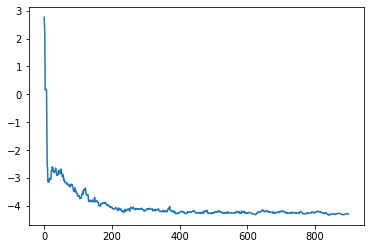

In [194]:
import matplotlib.pyplot as plt

El = [out[i]['E'] for i in range(len(out))]
tl = [i for i in range(len(El))]

plt.plot(tl,El)

In [195]:
import pickle

file_to_store = open("VQE_UpOnly_T"+str(T)+"_Aa_"+str(A_a)+"_aa_"+str(a_a)+"_ca_"+str(c_a)+"_betaa_"+str(beta_a)+"_gammaa_"+str(gamma_a)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+".pickle", "wb")

pickle.dump(out, file_to_store)

In [197]:
out[899]['alpha']

array([-0.35887671,  0.14254231,  0.39481956,  0.30949696,  0.72049282,
        0.28303435])

In [198]:
out[899]['phi']

array([[ 1.94475647, -2.23816076, -0.81602088, -0.08454062],
       [-0.22680081,  0.28485671,  0.85488709,  2.22526818]])

In [214]:
psi = np.transpose(y)
order = np.argsort(e)

e[order[0]]
psi[order[0]]

psi_C = []
for c in range(0,Nc):
    psi_c = []
    for i in range(0,Ndown):
        psi_ci = np.real(psi[order[0]][Ndown*c + i])
        if psi_ci > 10**(-10):
            psi_c.append(psi_ci)
        else:
            psi_c.append(0)
    #print(psi_c)
    psi_C.append(psi_c)

In [218]:
print(psi_C[0])
print(psi_C[1])

[0, 0, 0, 0, 0, 0, 0, 0.2902728396560092, 0, 0, 0, 0.2900706845542134, 0, 0.20888559926627817, 0.2087401247891156, 0]
[0, 0, 0, 0, 0, 0, 0, 0.2756623271840448, 0, 0, 0, 0.22428995248703212, 0, 0.27566232718404493, 0.2242899524870322, 0]


# Issue: $|\psi_{\downarrow}>$ can be different for different spin up states.  I should have instead:

$$|\psi> = \sum_c \alpha_c|c>|\psi_{\downarrow c}> $$



This gives us 

\begin{equation}
\begin{split}
<\psi|H|\psi> &= \sum_{c,c'}\alpha_c\alpha_{c'}^{*}<c'|<\psi_{\downarrow c'}| H|c>|\psi_{\downarrow c}> 
\\
& = \sum_{c,c'}\alpha_c\alpha_{c'}^{*} \left( <c'|\hat{K}_{\uparrow}|c><\psi_{\downarrow c'}|\psi_{\downarrow c}> + \delta_{c',c}<\psi_{\downarrow c}|\hat{K}_{\downarrow}|\psi_{\downarrow c}> + u\sum_i <c'|\hat{n}_{i\uparrow}|c><\psi_{\downarrow c'}|\hat{n}_{i\downarrow} |\psi_{\downarrow c}>   \right)
\\
& = \sum_{c,c'}\alpha_c\alpha_{c'}^{*} \left( k_{c',c}<\psi_{\downarrow c'}|\psi_{\downarrow c}> + \delta_{c',c}\sum_i\left( t<\psi_{\downarrow c}|X_i X_{i+1} |\psi_{\downarrow c}> +t<\psi_{\downarrow c}|Y_i Y_{i+1} |\psi_{\downarrow c}> + u_{i,c}<\psi_{\downarrow c}|Z_i |\psi_{\downarrow c}> + u_{i,c} \right) \right)
\end{split}
\end{equation}

What do we do with this term: $<\psi_{\downarrow c'}|\psi_{\downarrow c}>$ ?

It looks like we will need the extra qubit after all so that we can do 

$$|\psi_{\downarrow c c'}> = |0>|\psi_{\downarrow c}> + |1>|\psi_{\downarrow c'}> $$